In [1]:
#Importing necessary packages
import pandas as pd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

### Loading the Data

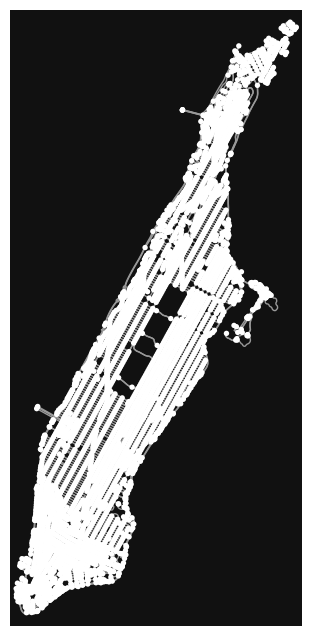

In [2]:
#Dowloading the Manhattan street network and visualizing it
G = ox.graph_from_place("Manhattan, New York, USA", network_type="drive")
fig, ax = ox.plot.plot_graph(G)

In [3]:
#Loading the data with the firehouse coordinates
firehouse_listing = pd.read_csv("FDNY_Firehouse_Listing_20250401.csv")

In [4]:
#Extracting the information of Manhattan fire stations only
manhattan_firestations = firehouse_listing[firehouse_listing["Borough"] == "Manhattan"]
manhattan_firestations

,FacilityName,FacilityAddress,Borough,Postcode,Latitude,Longitude,Community Board,Community Council,Census Tract,BIN,BBL,NTA
0,Engine 4/Ladder 15,42 South Street,Manhattan,10005,40.703694,-74.007717,101,1,7,1000867,1000350001,Battery Park City-Lower Manhattan
1,Engine 6,49 Beekman Street,Manhattan,10038,40.709971,-74.005395,101,1,1501,1001287,1000930030,Battery Park City-Lower Manhattan
2,Manhattan Borough Command/Battalion 1/Engine 7...,100 Duane Street,Manhattan,10007,40.715339,-74.006300,101,1,33,1001647,1001500025,SoHo-TriBeCa-Civic Center-Little Italy
3,Ladder 8,14 N. Moore Street,Manhattan,10013,40.719574,-74.006620,101,1,33,1002150,1001890035,SoHo-TriBeCa-Civic Center-Little Italy
4,Engine 9/Ladder 6,75 Canal Street,Manhattan,10002,40.715408,-73.992834,103,1,16,1003898,1003000030,Chinatown
5,Battalion 4/Engine 15/Ladder 18,25 Pitt Street,Manhattan,10002,40.716439,-73.983927,103,1,12,1004078,1003420060,Lower East Side
6,Engine 28/Ladder 11,222 East 2 Street,Manhattan,10009,40.721879,-73.982526,103,2,2202,1004608,1003850058,Lower East Side
7,Engine 5,340 East 14 Street,Manhattan,10003,40.731494,-73.983407,103,2,40,1006520,1004550028,East Village
8,Division 1/Ladder 20,253 Lafayette Street,Manhattan,10012,40.723026,-73.996571,102,1,43,1007523,1004950007,SoHo-TriBeCa-Civic Center-Little Italy
9,Engine 33/Ladder 9,42 Great Jones Street,Manhattan,10012,40.726986,-73.992526,102,1,5502,1008526,1005310049,West Village


In [5]:
#converting graph to projected form
G_proj = ox.project_graph(G)

In [6]:
#converting to geodataframe
geometry = [Point(xy) for xy in zip(manhattan_firestations["Longitude"], manhattan_firestations["Latitude"])]
gdf_firestations = gpd.GeoDataFrame(manhattan_firestations, geometry=geometry, crs="EPSG:4326")

#projecting to the same as the projection graph
gdf_firestations_proj = gdf_firestations.to_crs(G_proj.graph['crs'])

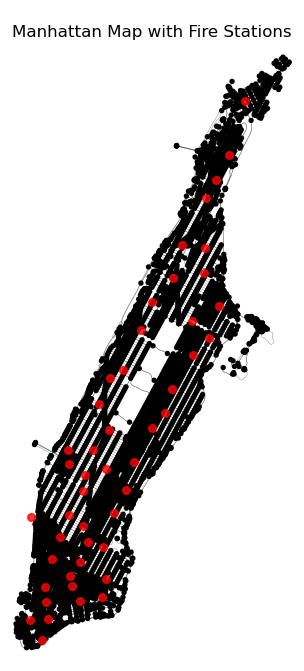

In [7]:
#plotting
fig, ax = ox.plot_graph(G_proj, show=False, close=False, bgcolor="white", edge_color="black", edge_alpha=0.5, 
                        node_color="black", edge_linewidth=0.3)
gdf_firestations_proj.plot(ax=ax, color='red', markersize=30, alpha=0.8, zorder=3)
plt.title("Manhattan Map with Fire Stations")
plt.show()

### Constructing the graph

Constructing a weighted graph:

In [ ]:
G_weighted = nx.Graph() #undirected, assuming all streets are two way streets

for u, v, data in G_proj.edges(data=True):
    weight = data.get('length', 1) #defaults to 1 if the length is missing
    G_weighted.add_edge(u, v, weight=weight)

for node, data in G_proj.nodes(data=True):
    G_weighted.add_node(node, **data)

Finding the nearest node in the graph to represent each firehouse

In [11]:
firehouse_nodes = ox.distance.nearest_nodes(
    G_proj,
    X=gdf_firestations_proj.geometry.x,
    Y=gdf_firestations_proj.geometry.y
)

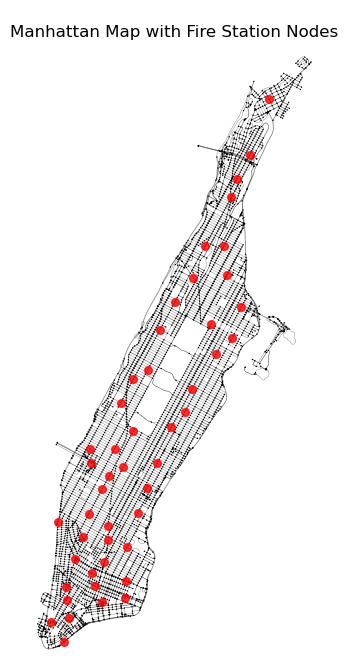

In [13]:
#plotting the source nodes:
node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}
firehouse_x = [node_positions[node][0] for node in firehouse_nodes]
firehouse_y = [node_positions[node][1] for node in firehouse_nodes]

fig, ax = ox.plot_graph(G_proj, show=False, close=False, bgcolor='white',
                        edge_color='black', edge_alpha=0.5,
                        node_color='black', node_size=1,
                        edge_linewidth=0.3)
ax.scatter(firehouse_x, firehouse_y, c='red', s=30, alpha=0.8, zorder=3, label='Firehouse')
plt.title("Manhattan Map with Fire Station Nodes")
plt.show()

### Simulating an Emergency